# Preliminary note to the user

#### The applied models, including the Grid search, are requiring extensive computational power, which might lead to a long run-time. Therefore, the notebook is extended by the data preparation and feature engineering code, though it is not executed yet as the data was originally loaded from an external file. Nonetheless, the code can be executed as submitted and will produce the shown results.

# Packages

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import warnings
from pandas.core.common import SettingWithCopyWarning
import pickle
from matplotlib import pyplot as plt

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Import Data

In [3]:
# Derive path
dirname = os.path.abspath(os.getcwd())

# Original files
acquisition = pd.read_csv(f"{dirname[:-17]}/data/acquisitions.csv")
investments = pd.read_csv(f"{dirname[:-17]}/data/investments.csv")
organisations = pd.read_csv(f"{dirname[:-17]}/data/organisations.csv")
rounds = pd.read_csv(f"{dirname[:-17]}/data/rounds.csv")

# External data
PE = pd.read_csv(f"{dirname[:-17]}/data/PE_list.csv",index_col=0)
anninflation = pd.read_csv(f"{dirname[:-17]}/data/Inflation.csv")
realint = pd.read_csv(f"{dirname[:-17]}/data/real_interest.csv")
gdpgrowth = pd.read_csv(f"{dirname[:-17]}/data/gdpgrowth.csv")

/Users/nilsmartens/opt/anaconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Create Function

## Function to reduce memory used

In [4]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

# Data Preparation 

## Data Preparation: Organisations

In [5]:
# Drop elements not used
organisations = organisations.drop(["homepage_url", "category_list"],axis=1)

# Combining markets with rare observations but high fundings to High_funding_market
organisations["market"] = np.where(organisations["market"].isin([" B2B Express Delivery ", " Cloud-Based Music ", " Content Creators ", " Custom Retail ", " Development Platforms ", " Film Production ", " Food Processing ", " Hospitals ", " Natural Gas Uses ", " Oil ", " Oil and Gas ", " Recreation ", " Renewable Energies ", " Trading ", " Solar ", " Renewable Energies ", " TV Production "]),
        "High_funding_market",
        organisations["market"])

# Replace markets with less than 100 observations by " Other "
organisations["market"] = np.where(organisations["market"].isin(organisations["market"].value_counts().loc[lambda x: x>=100].index), organisations["market"], " Other ")

# Replace NaNs in state_code by Non_US
organisations.loc[organisations["state_code"].isna(),"state_code"] = "Non_US"

# Change nan values to string "No_status"
organisations["status"] = np.where(organisations["status"].isna(), "No_status", organisations["status"])

# Create new code column with USA state codes and country codes
organisations["country_state_code"] = np.where(organisations["country_code"] == "USA", organisations["state_code"], organisations["country_code"])

# Change variables to datatime
for i in ("founded_at", "first_funding_at", "last_funding_at"):
    organisations[i] = pd.to_datetime(organisations[i])

# Create Time Delta between founding and first funding as well as first and last funding
organisations["TDelta_1"] = (organisations["first_funding_at"] - organisations["founded_at"]).dt.days.astype('int')
organisations["TDelta_2"] = (organisations["last_funding_at"] - organisations["first_funding_at"]).dt.days.astype('int')

# Create Year and Month variables for founding, first funding and last funding
for i in ("founded_at", "first_funding_at", "last_funding_at"):
    organisations[f'{i}_year'] = pd.DatetimeIndex(organisations[i]).year
    organisations[f'{i}_month'] = pd.DatetimeIndex(organisations[i]).month

# Save the dataframe as csv
#organisations.to_csv("organisations_cleaned.csv")

## Data Preparation: Rounds

In [6]:
# Drop meaningless column
rounds = rounds.drop("Unnamed: 16", axis=1)

# Replacing all funding_round_codes for non Ventures Capital with nan
rounds.loc[(~rounds["funding_round_code"].isna()) & (rounds["funding_round_type"] != "venture"), "funding_round_code"] = float("nan")

# Grouping funding round codes E to H togehter due to limited observations (E+)
rounds["funding_round_code"] = np.where(rounds["funding_round_code"].isin(['E', 'F', 'G', 'H']), "E+", rounds["funding_round_code"])

# Replacing post_ipo_debt with debt_financing and secondary_market with private_equity in column funding_round_type_code due to lessor observations
rounds["funding_round_type_code"] = np.where(~rounds["funding_round_code"].isna(), rounds["funding_round_type"]+"_"+rounds["funding_round_code"], rounds["funding_round_type"])
rounds["funding_round_type_code"] = np.where(rounds["funding_round_type_code"] == "post_ipo_debt", "debt_financing", rounds["funding_round_type_code"])
rounds["funding_round_type_code"] = np.where(rounds["funding_round_type_code"] == "secondary_market", "private_equity", rounds["funding_round_type_code"])

# Changing funded_at to datetime and create the average delta in between fundings
rounds["funded_at"] = pd.to_datetime(rounds["funded_at"], errors='coerce')
rounds.loc[rounds["funded_at"].isna(),"funded_at"] = pd.to_datetime(1, unit='D', origin=pd.Timestamp('1900-01-01'))
rounds["Fund_avgDelta"] = rounds.groupby("company_permalink")["funded_at"].transform(lambda x: ((x.max() - x.min()).days / x.count()))

# Dropping the test case
rounds = rounds[~rounds["company_name"].isin(["new test company", "test company"])]

In [7]:
# Creating columns with macro economic indicators
for i in rounds.index:
    try:
        rounds.loc[i,"funding_inflation"] = anninflation.loc[anninflation["country_code"] == rounds.loc[i,"company_country_code"], 
                                              str(rounds.loc[i,"funded_year"].item())[0:4]].item()
        rounds.loc[i,"funding_int"] = realint.loc[realint["country_code"] == rounds.loc[i,"company_country_code"], 
                                              str(rounds.loc[i,"funded_year"].item())[0:4]].item()
        rounds.loc[i,"gdpgrowth"] = gdpgrowth.loc[gdpgrowth["country_code"] == rounds.loc[i,"company_country_code"], 
                                              str(rounds.loc[i,"funded_year"].item())[0:4]].item()
    except:
        try:
            rounds.loc[i,"funding_inflation"] = anninflation.loc[anninflation["country_code"] == "WLD", 
                                                  str(rounds.loc[i,"funded_year"].item())[0:4]].item()
            rounds.loc[i,"funding_int"] = realint.loc[realint["country_code"] == "WLD", 
                                              str(rounds.loc[i,"funded_year"].item())[0:4]].item()
            rounds.loc[i,"gdpgrowth"] = gdpgrowth.loc[gdpgrowth["country_code"] == "WLD", 
                                              str(rounds.loc[i,"funded_year"].item())[0:4]].item()
        except:
            pass

In [8]:
# Adding inconsistent macro economic indicators 
for i in rounds.loc[rounds["funding_inflation"].isna()].index:
    try:
        rounds.loc[i,"funding_inflation"] = anninflation.loc[anninflation["country_code"] == "WLD", 
                                                  str(rounds.loc[i,"funded_year"].item())[0:4]].item()
    except:
            pass

for i in rounds.loc[rounds["funding_int"].isna()].index:
    try:
        rounds.loc[i,"funding_int"] = realint.loc[realint["country_code"] == "WLD", 
                                              str(rounds.loc[i,"funded_year"].item())[0:4]].item()
    except:
            pass

for i in rounds.loc[rounds["gdpgrowth"].isna()].index:
    try:
        rounds.loc[i,"gdpgrowth"] = gdpgrowth.loc[gdpgrowth["country_code"] == "WLD", 
                                              str(rounds.loc[i,"funded_year"].item())[0:4]].item()
    except:
            pass

In [9]:
# Drop companies with no observations in fund year, and cannot be matched with macro data
rounds = rounds[~rounds["company_permalink"].isin(rounds.loc[rounds["funded_year"].isna(),"company_permalink"].unique())]

# Drop companies with no inflation data due to a early founding
rounds = rounds[~rounds["company_permalink"].isin(rounds.loc[rounds["funding_inflation"].isna(),"company_permalink"].unique())]

# Calculate the mean of the macro data per company
for i in ["funding_inflation","funding_int","gdpgrowth"]:
    rounds[i] = rounds.groupby("company_permalink")[i].transform(lambda x: np.mean(x))

# Sort the investments by date
rounds = rounds.sort_values("funded_month")

# Save the dataframe as a csv
#rounds.to_csv("rounds_cleaned.csv")

# Drop all earlier observations per comapny
rounds_short = rounds.drop_duplicates(subset=["company_permalink"], keep="last")

## Data Preparation: Investments

In [10]:
# Derive the Investor Type
investments["Investor_type"] = investments["investor_permalink"].str.split("/", expand = True)[1]
investments[investments["Investor_type"].isna()]["company_permalink"].str.split("/", expand = True)[1].unique()
investments["Investor_type"] = np.where(investments["Investor_type"].isna(), 'organization',investments["Investor_type"])

# Create variable describing the type of investors (person, organization or both)
investments["Investor_type"] = investments.groupby("company_permalink")["Investor_type"].transform(lambda x: " ".join(x))
investments["Investor_type"] = list(map(sorted,list(map(list,map(set,investments["Investor_type"].str.split(" "))))))
investments["Investor_type"] = ["/".join(x) for x in investments["Investor_type"]]

# Create a variable containing a list of the names of all investors per investment
investments["investor_name"] = np.where(investments["investor_name"].isna(), "Unknown", investments["investor_name"])
investments["investor_list"] = investments.groupby("company_permalink")["investor_name"].transform(lambda x: "-".join(x))
investments["investor_list"] = list(map(list,map(set,investments["investor_list"].str.split("-"))))

# Adjust the investor market for having only markets with more than 1000 observations
investments["investor_market"] = np.where(investments["investor_market"].isin(list(investments["investor_market"].value_counts().loc[lambda x: x > 1000].index)),
                                          investments["investor_market"],
                                          "Other")

# Create a list the countries of all investors with more than 500 observations
investments["investor_country_code"] = np.where(investments["investor_country_code"].isna(), 
                                                "Unknown", 
                                                investments["investor_country_code"])
investments["investor_country_code"] = np.where(investments["investor_country_code"].isin(list(investments["investor_country_code"].value_counts().loc[lambda x: x < 500].index)), 
                                                "Other", 
                                                investments["investor_country_code"])
investments["investor_country_list"] = investments.groupby("company_permalink")["investor_country_code"].transform(lambda x: "-".join(x))
investments["investor_country_list"] = list(map(list,map(set,investments["investor_country_list"].str.split("-"))))

# Create a list of the countries/states of all investors with more than 500 observations
investments["investor_state_code"] = np.where(investments["investor_state_code"].isna(), "Unknown", investments["investor_state_code"])
investments["investor_country_state_list"] = investments["investor_country_code"]
investments["investor_country_state_list"] = np.where((investments["investor_country_state_list"] == "USA") & (investments["investor_state_code"].isin(list(investments["investor_state_code"].value_counts().loc[lambda x: x >= 500].index))), 
                                                      investments["investor_state_code"],
                                                      investments["investor_country_state_list"])
investments["investor_country_state_list"] = investments.groupby("company_permalink")["investor_country_state_list"].transform(lambda x: "-".join(x))
investments["investor_country_state_list"] = list(map(list,map(set,investments["investor_country_state_list"].str.split("-"))))

# Create a variable counting the number of investors per investment
investments["investor_number"] = investments.groupby("company_permalink")["company_name"].transform('count')

# Identify the most succesful investors and create a dummy on company level
investments["PE"] = np.where(investments["investor_name"].isin(PE["NameDataset"]), 1,0)
investments["PE"] = investments.groupby("company_permalink")["PE"].transform(lambda x: max(x))

# Dropping the test case
investments = investments[investments["company_name"] != "test company"]

# Sort the investments by date
investments = investments.sort_values("funded_month")

# Save the dataframe as csv
#investments.to_csv("investments_cleaned.csv")

# Drop all earlier observations per comapny
investments_short = investments.drop_duplicates(subset=["company_permalink"], keep="last")

# Merge

In [11]:
# Define the relevant columns used for the final dataframe
List_variables_org = ["permalink","name","market","funding_total_usd","status","funding_rounds","country_code","state_code","country_state_code","TDelta_1","TDelta_2","founded_at_year","founded_at_month","first_funding_at_year","first_funding_at_month","last_funding_at_year","last_funding_at_month"]
List_variables_rounds = ["company_permalink","funding_round_type_code","Fund_avgDelta","funding_inflation","funding_int","gdpgrowth"]
List_variables_inv = ["company_permalink","investor_market","Investor_type","investor_list","investor_country_list","investor_country_state_list","investor_number","PE"]

# Merge the organisation abd round dataframe 
Org_Rounnd = pd.merge(organisations.loc[:,List_variables_org],
         rounds_short.loc[:,List_variables_rounds],
         left_on = "permalink",
         right_on = "company_permalink").drop(["company_permalink"], axis=1)

# Save the new dataframe
#Org_Rounnd.to_csv("Merge_Org_Round.csv")

## Merge: Organisation, Rounds and Investments

In [12]:
# Second merge adding the investment dataframe
All = pd.merge(Org_Rounnd,
         investments_short.loc[:,List_variables_inv],
         left_on = "permalink",
         right_on = "company_permalink").drop(["company_permalink"], axis=1)

# Save the new dataframe
#All.to_csv("Merge_Org_Round_Inv.csv")

# Drop unused Data

In [13]:
# Drop unused dataframes
del Org_Rounnd, investments_short, investments, rounds_short, rounds, organisations, acquisition, PE, anninflation, realint, gdpgrowth

# Import Data from external sources

In [14]:
# Load cleaned data from the script of question 1 from the repository
'''dirname = os.path.dirname(os.getcwd())
Org_Rounnd = pd.read_csv(os.path.join(dirname, "Merge_Org_Round.csv"))
All = pd.read_csv(os.path.join(dirname, "Merge_Org_Round_Inv.csv"))'''

'dirname = os.path.dirname(os.getcwd())\nOrg_Rounnd = pd.read_csv(os.path.join(dirname, "Merge_Org_Round.csv"))\nAll = pd.read_csv(os.path.join(dirname, "Merge_Org_Round_Inv.csv"))'

## Rename Data for Analysis 

In [15]:
ignored_column_names = ['permalink', 'name', 'state_code', 'country_code', 'investor_country_list',
                       'investor_country_state_list', 'investor_list'] 
data = All
data = data[data.columns[~data.columns.isin(ignored_column_names)]]
data.head(5)

,market,funding_total_usd,status,funding_rounds,country_state_code,TDelta_1,TDelta_2,founded_at_year,founded_at_month,first_funding_at_year,...,last_funding_at_month,funding_round_type_code,Fund_avgDelta,funding_inflation,funding_int,gdpgrowth,investor_market,Investor_type,investor_number,PE
0,News,1750000.0,acquired,1,NY,29,0,2012,6,2012,...,6,seed,0.0,2.069337,1.307083,2.249546,Finance,organization/person,6,0
1,Other,40000.0,operating,1,EST,-78,0,2012,10,2012,...,8,seed,0.0,3.933400,5.970000,3.228200,Other,organization,1,0
2,E-Commerce,40000.0,operating,1,CHL,414,0,2012,1,2013,...,2,seed,0.0,1.789556,7.144020,4.045004,Other,organization,1,0
3,Search,40000.0,operating,1,OR,1330,0,2008,1,2011,...,8,seed,0.0,3.156842,1.137338,1.550836,Other,organization,1,0
4,Curated Web,2535000.0,acquired,2,CA,-181,411,2010,7,2010,...,2,venture_A,205.5,2.398443,1.599038,2.057301,Other,organization/person,10,0


In [16]:
# Group countries that have less than 100 observations to "Other" Category
data.loc[:, data.columns == "country_state_code"] = np.where(data["country_state_code"].isin(data["country_state_code"].value_counts().loc[lambda x: x>=100].index), data["country_state_code"], "Other")

# Group years that are before 2005 into one category to avoid recency skewness
year_columns = ['founded_at_year', 'first_funding_at_year', 'last_funding_at_year']
for i in year_columns:
    data.loc[:, data.columns == i] = np.where(data[i] <= 2004, "Pre_2005", data[i])

In [17]:
data.dtypes

market                      object
funding_total_usd          float64
status                      object
funding_rounds               int64
country_state_code          object
TDelta_1                     int64
TDelta_2                     int64
founded_at_year             object
founded_at_month             int64
first_funding_at_year       object
first_funding_at_month       int64
last_funding_at_year        object
last_funding_at_month        int64
funding_round_type_code     object
Fund_avgDelta              float64
funding_inflation          float64
funding_int                float64
gdpgrowth                  float64
investor_market             object
Investor_type               object
investor_number              int64
PE                           int64
dtype: object

In [18]:
data = reduce_mem_usage(data)

Memory usage of properties dataframe is : 3.3384323120117188  MB
******************************
Column:  funding_total_usd
dtype before:  float64
dtype after:  uint64
******************************
******************************
Column:  funding_rounds
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  TDelta_1
dtype before:  int64
dtype after:  int16
******************************
******************************
Column:  TDelta_2
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  founded_at_month
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  first_funding_at_month
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  last_funding_at_month
dtype before:  int64
dtype after:  uint8
******************************
******************************
Col

In [19]:
dummies = pd.DataFrame()
for i in data.columns:
    if pd.api.types.is_object_dtype(data[i]):
        data[i] = data[i].astype("category")
        categories = pd.get_dummies(data[i], drop_first=True)
        dummies = pd.concat([dummies, categories], axis=1)
        data = pd.concat([data, categories], axis=1)

## Train/Test Split



The data is split into a train- and a testset with 70% of the observations in the trainset. For the split stratification according to the variable 'last_funding_at_year' is performed. This helps to have a more similar distribution of the observations in the train- and the testset. The assumption here is that companies having a funding round in the same year were subject to similar underlying economic conditions. 

In [20]:
df = data
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'funding_total_usd'], 
                                                    df.loc[:, df.columns == 'funding_total_usd'],
                                                    train_size=0.7,
                                                    random_state=1,
                                                    stratify=df[['last_funding_at_year']])

# drop categorical variables - all have been encoded in dummies before
X_train = X_train.select_dtypes(include=np.number)
X_test = X_test.select_dtypes(include=np.number)


# Modelling

## Packages

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Lasso Polynomial Regression

### Grid Search
The grid search was performed iteratively and the parameters in the cell below only represent the very last interation. This process was chosen as to keep the processing time feasible and not produce errors by performing grid searches with too many models. 
In the first step, we chose a very large range and steps of parameters  to narrow down the optimal range of each of the parameters based on the result of the 5-fold CV. In the next steps we kept reducing the range with decreasing steps to narrow down the optimal parameters. 

In [42]:
# Define parameters for Grid Search
# The grid search was performed over multiple iterations and the parameters here only represent the last iteration
Lasso_params = {'lasso__alpha': range(750000,1000000,500)}

In [43]:
# Performing Grid Search
modelLasso = (GridSearchCV(make_pipeline(StandardScaler(), PolynomialFeatures(1), Lasso()), 
                         param_grid=Lasso_params, verbose=1, n_jobs=-1)).fit(X_train, y_train.values.ravel())
Lasso_best_params = modelLasso.best_params_
print(Lasso_best_params)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'lasso__alpha': 838500}


In [197]:
# Model score in the Test Set
print(f"Test Set")
print(f"R2   : {modelLasso.score(X_test, y_test):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_test, modelLasso.predict(X_test), squared=False)):,}")

Test Set:
R2   : 30.64%
RMSE : 46,804,446


In [198]:
# Model score in the Train Set
print(f"Train Set")
print(f"R2   : {modelLasso.score(X_train, y_train):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_train, modelLasso.predict(X_train), squared=False)):,}")

Train Set
R2   : 20.46%
RMSE : 78,050,916


### Comments
We see that the R2 for the train set is ~10 percentage points lower than that of the test set and the RMSE of the train set is ~1.67x higher than that of the test set. This means that average deviation between the predicted total funding amount made by the model and the actual value is lower in the train set, however the proportion of the variation explained by the model is also lower in the train set.

In [199]:
# Save Model as Pickle
'''
filename = 'Lasso_final_model.sav'
if not os.path.exists(os.path.join(dirname, filename)):
    pickle.dump(modelLasso, open(filename, 'wb'))
'''

## Gradient Boosting

### Grid Search
The grid search was performed iteratively and the parameters in the cell below only represent the very last interation. This process was chosen as to keep the processing time feasible and not produce errors by performing grid searches with too many models. In the first step, we chose a very large range and steps of parameters to narrow down the optimal range of each of the parameters based on the result of the 5-fold CV. In the next steps we kept reducing the range with decreasing steps to narrow down the optimal parameters.

In [148]:
# Define parameters for Grid Search
# The grid search was performed over multiple iterations and the parameters here only represent the last iteration
Boosting_params = {'gradientboostingregressor__learning_rate': [0.0001, 0.001, 0.002, 0.003],
                   'gradientboostingregressor__n_estimators' : [1000, 1100, 1200],
                   'gradientboostingregressor__max_depth'    : [2, 3, 4]}

In [49]:
# Performing Grid Search
modelBoosting = (GridSearchCV(make_pipeline(GradientBoostingRegressor()), 
                              param_grid=Boosting_params, verbose=3, n_jobs=-1)).fit(X_train, y_train.values.ravel())
Boosting_best_params = modelBoosting.best_params_
print(Boosting_best_params)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'gradientboostingregressor__learning_rate': 0.002, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 1100}


In [200]:
# Model score in the Test Set
print(f"Test Set")
print(f"R2   : {modelBoosting.score(X_test, y_test):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_test, modelBoosting.predict(X_test), squared=False)):,}")

Test Set
R2   : 34.60%
RMSE : 45,451,228


In [201]:
# Model score in the Train Set
print(f"Train Set")
print(f"R2   : {modelBoosting.score(X_train, y_train):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_train, modelBoosting.predict(X_train), squared=False)):,}")

Train Set
R2   : 58.43%
RMSE : 56,427,457


### Comments
We see that the R2 for the train set is ~24 percentage points higher than that of the test set and the RMSE of the train set is ~1.24x higher than that of the test set. This means that average deviation between the predicted total funding amount made by the model and the actual value is lower in the test set, however the proportion of the variation explained by the model is also lower in the test set.

In [202]:
# Save Model as Pickle
'''
filename = 'Boosting_final_model.sav'
if not os.path.exists(os.path.join(dirname, filename)):
    pickle.dump(modelBoosting, open(filename, 'wb'))
'''

## Support Vector Machine

### Grid Search
The grid search was performed iteratively and the parameters in the cell below only represent the very last interation. This process was chosen as to keep the processing time feasible and not produce errors by performing grid searches with too many models. In the first step, we chose a very large range and steps of parameters to narrow down the optimal range of each of the parameters based on the result of the 5-fold CV. In the next steps we kept reducing the range with decreasing steps to narrow down the optimal parameters.

In [169]:
# Define parameters for Grid Search
# The grid search was performed over multiple iterations and the parameters here only represent the last iteration
SVR_params = {'svr__C':[400000000, 450000000, 500000000],'svr__gamma': [3e-3, 4e-3, 5e-3]}

In [170]:
# Performing Grid Search
modelSVR = (GridSearchCV(make_pipeline(StandardScaler(), SVR()), 
                         param_grid=SVR_params, verbose=1, n_jobs=-1)).fit(X_train, y_train.values.ravel())
SVR_best_params = modelSVR.best_params_
print(SVR_best_params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'svr__C': 500000000, 'svr__gamma': 0.003}


In [203]:
# Model score in the Test Set
print(f"Test Set")
print(f"R2   : {modelSVR.score(X_test, y_test):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_test, modelSVR.predict(X_test), squared=False)):,}")

Test Set
R2   : 29.90%
RMSE : 47,053,501


In [204]:
# Model score in the Train Set
print(f"Train Set")
print(f"R2   : {modelSVR.score(X_train, y_train):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_train, modelSVR.predict(X_train), squared=False)):,}")

Train Set
R2   : 28.09%
RMSE : 74,212,911


### Comments
We see that the R2 for the train set is only ~1 percentage points lower than that of the test set and the RMSE of the train set is ~1.58x higher than that of the test set. This means that average deviation between the predicted total funding amount made by the model and the actual value is lower in the test set, as well as the proportion of the variation explained by the model being higher in the test set.

In [205]:
# Save Model as Pickle
'''
filename = 'SVR_final_model.sav'
if not os.path.exists(os.path.join(dirname, filename)):
    pickle.dump(modelSVR, open(filename, 'wb'))
'''

## Random Forest

### Grid Search
The grid search was performed iteratively and the parameters in the cell below only represent the very last interation. This process was chosen as to keep the processing time feasible and not produce errors by performing grid searches with too many models. In the first step, we chose a very large range and steps of parameters to narrow down the optimal range of each of the parameters based on the result of the 5-fold CV. In the next steps we kept reducing the range with decreasing steps to narrow down the optimal parameters.

In [145]:
# Define parameters for Grid Search
# The grid search was performed over multiple iterations and the parameters here only represent the last iteration
RF_params = {'randomforestregressor__n_estimators': [880, 900, 920],
             'randomforestregressor__max_features': [22, 23, 24, 25]}

In [146]:
# Performing Grid Search
modelRF = (GridSearchCV(make_pipeline(RandomForestRegressor()), 
                         param_grid=RF_params, verbose=1, n_jobs=-1)).fit(X_train, y_train.values.ravel())
RF_best_params = modelRF.best_params_
print(RF_best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'randomforestregressor__max_features': 24, 'randomforestregressor__n_estimators': 900}


In [206]:
# Model score in the Test Set
print(f"Test Set")
print(f"R2   : {modelRF.score(X_test, y_test):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_test, modelRF.predict(X_test), squared=False)):,}")

Test Set
R2   : 36.16%
RMSE : 44,905,110


In [207]:
# Model score in the Train Set
print(f"Train Set")
print(f"R2   : {modelRF.score(X_train, y_train):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_train, modelRF.predict(X_train), squared=False)):,}")

Train Set
R2   : 89.19%
RMSE : 28,770,305


### Comments
We see that the R2 for the train set is a large ~53 percentage points higher than that of the test set and the RMSE of the train set is ~0.64x as much as that of the test set. This means that average deviation between the predicted total funding amount made by the model and the actual value is higher in the test set, as well as the proportion of the variation explained by the model being lower in the test set.

In [208]:
# Save Model as Pickle
'''
filename = 'RF_final_model.sav'
if not os.path.exists(os.path.join(dirname, filename)):
    pickle.dump(modelRF, open(filename, 'wb'))
'''

Since this is the best of our models based upon both the highest R2 and the lowest RMSE, we want to see the most influential variables within it.
Variable Importance Score of the 20 most important features:

Text(0.5, 0, 'Random Forest Feature Importance')

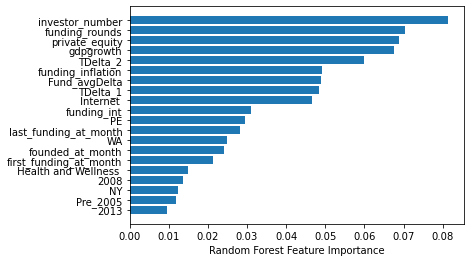

In [265]:
sorted_idx = modelRF.best_estimator_.named_steps["randomforestregressor"].feature_importances_.argsort()
sorted_idx = sorted_idx[len(sorted_idx)-20:len(sorted_idx)]
plt.barh(X_train.columns[sorted_idx], modelRF.best_estimator_.named_steps["randomforestregressor"].feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Comments 
We see that several of the top variables in influencing the target variable of total funds were previously mentioned. - it is important to note that, unlike regression coefficients, a high variable importance score does not mean that a variable positively influences the target variabale. It could also be a strong factor in negatively influencing it.

First, the number of investors a sartup has, plays a larger role than any other variable in predicting total funding. This is likely a positive relationship since logically, more investors means more contributions, ceteris paribus. 

Second, funding rounds are important for a similar logical reason as the number of investors. It is interesing to see that the number of investors and funding rounds and more important than being in the high_funding_market classification, which we predicted would be a large influence on total funding.

Third, private_equity, a category of funding round type code, would indicate that having this type of investor
influences the amount of total funding a startup recieves, whether that be higher or lower than other categories.

Fourth, one of the macroeconomic variables we added appears, gdpgrowth. This would indicate that the overall monetary growth of the country in which the startup is in affects the total amount of funding they recieve. the two other macroeconomic variables, inflation and interest rate, do not affect the model as much as expected.

Fifth, TDelta_2, which represents the time between the first and last funding round appears to have a relatively strong influence on the total funding as well as the TDelta_1 variable, which represents the time between the founding date of the startup and the first funding round. The logic behind this is that we think the time it takes between founding and funding round dates could be indicative of the success of the startup and thus, how much funding they would recieve overall.

## Neural Network

### Grid Search
The grid search was performed iteratively and the parameters in the cell below only represent the very last interation. This process was chosen as to keep the processing time feasible and not produce errors by performing grid searches with too many models. In the first step, we chose a very large range and steps of parameters to narrow down the optimal range of each of the parameters based on the result of the 5-fold CV. In the next steps we kept reducing the range with decreasing steps to narrow down the optimal parameters.

In [130]:
# Define parameters for Grid Search
# The grid search was performed over multiple iterations and the parameters here only represent the last iteration
NN_params = {'mlpregressor__hidden_layer_sizes': [(128), (128,128,128,128), (16,16,16,16,16,16,16,16,16,16,16)],
             'mlpregressor__activation': ["relu"],
             'mlpregressor__early_stopping':[True],
             'mlpregressor__validation_fraction':[0.2, 0.1],
             'mlpregressor__n_iter_no_change': [10]
            }

In [131]:
# Performing Grid Search
modelNN = (GridSearchCV(make_pipeline(StandardScaler(), MLPRegressor()), 
                         param_grid=NN_params, verbose=3, n_jobs=-1)).fit(X_train.values, y_train.values.ravel())
NN_best_params = modelNN.best_params_
print(NN_best_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'mlpregressor__activation': 'relu', 'mlpregressor__early_stopping': True, 'mlpregressor__hidden_layer_sizes': (16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16), 'mlpregressor__n_iter_no_change': 10, 'mlpregressor__validation_fraction': 0.1}


In [211]:
# Model score in the Test Set
print(f"Test Set")
print(f"R2   : {modelNN.score(X_test.values, y_test):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_test, modelNN.predict(X_test.values), squared=False)):,}")

Test Set
R2   : 32.62%
RMSE : 46,133,614


In [212]:
# Model score in the Train Set
print(f"Train Set")
print(f"R2   : {modelNN.score(X_train.values, y_train):.2%}")
print(f"RMSE : {round(metrics.mean_squared_error(y_train, modelNN.predict(X_train.values), squared=False)):,}")

Train Set
R2   : 29.41%
RMSE : 73,526,546


### Comments
We see that the R2 for the train set is ~3.2 percentage points lower than that of the test set and the RMSE of the train set is ~1.59x higher than that of the test set. This means that average deviation between the predicted total funding amount made by the model and the actual value is higher in the train set, as well as the proportion of the variation explained by the model being lower in the train set.

In [213]:
# Save Model as Pickle
'''
filename = 'NN_final_model.sav'
if not os.path.exists(os.path.join(dirname, filename)):
    pickle.dump(modelNN, open(filename, 'wb'))
'''